In [2]:
import pandas as pd
import operator


from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.cross_validation import cross_val_score
from xgboost import XGBClassifier, XGBRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier
from xgboost import XGBClassifier

%pylab inline

import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [ ]:
http://srisai85.github.io/airfoil_noise/Airfoil_Noise_Prediction.html#/

In [3]:
raw_data = pd.read_csv("airfoil_self_noise.dat.txt", sep="\t", header=None)

The NASA data set comprises different size NACA 0012 airfoils at various wind tunnel speeds and angles of attack. The span of the airfoil and the observer position were the same in all of the experiments.

In [ ]:
http://airfoiltools.com/airfoil/details?airfoil=n0012-il

This problem has the following inputs: 
1. Frequency, in Hertzs. 
2. Angle of attack, in degrees. 
3. Chord length, in meters. 
4. Free-stream velocity, in meters per second. 
5. Suction side displacement thickness, in meters. 

The only output is: 
6. Scaled sound pressure level, in decibels. 

In [4]:
data = raw_data.rename(index=str, columns={0: "Freq", 1: "Angle_attack", 
                                               2: "Chord_length", 3: "Velocity", 4: "Disp_thick", 5: "Pres_level"})

In [5]:
data.head()

,Freq,Angle_attack,Chord_length,Velocity,Disp_thick,Pres_level
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461


In [6]:
import lightgbm as lgb
from sklearn import metrics
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import GridSearchCV

In [7]:
### Classification task

In [8]:
data["High_Pres_level"] = (data.Pres_level > data["Pres_level"].mean())*1.0

In [9]:
nu = 15.68e-06 # Kinematic Viscosity for air at 300K (27°C) is noted as 1.568e-5
c0 = 1450
data["Re"] = data["Velocity"]*data["Chord_length"]/nu # Re = Free Stream Velocity * Characteristic Length/Kinematic Viscosity
data["St"] = data["Freq"]*data["Disp_thick"]/data["Velocity"]
data["Stl"] = data["Freq"]*data["Chord_length"]/data["Velocity"]
data["Delta"] = data["Disp_thick"]/data["Chord_length"]
data["Ro"] = data["Re"]*data["St"]
data["Ma"] = data["Velocity"]/c0
data["Alpha"] = data["Angle_attack"]

In [10]:
data.columns

Index(['Freq', 'Angle_attack', 'Chord_length', 'Velocity', 'Disp_thick',
       'Pres_level', 'High_Pres_level', 'Re', 'St', 'Stl', 'Delta', 'Ro', 'Ma',
       'Alpha'],
      dtype='object')

In [11]:
y = data['High_Pres_level']
X = data[['St', 'Stl', 'Ro', 'Alpha', 'Delta', 'Re', 'Ma']]     
#X = data[['St', 'An', 'Dt', 'Re', 'Ma', 'Freq', 'Angle_attack', 'Chord_length', 'Disp_thick']]

In [12]:
def CorrelationSelector(X,y):
    columns = X.columns
    corr_data = dict([(abs(np.corrcoef(X[c],y)[0,1]),c) for c in columns if math.isnan(abs(np.corrcoef(X[c],y)[0,1]))==False])
    sorted_corr_data = sorted(corr_data.items(), key=operator.itemgetter(0), reverse=True)
    return sorted_corr_data

In [13]:
CorrelationSelector(X,y)

[(0.45944908018966, 'Ro'),
 (0.4377609279896385, 'Stl'),
 (0.39655026863002524, 'St'),
 (0.17045990450929885, 'Delta'),
 (0.16812878171161313, 'Alpha'),
 (0.1078198168418456, 'Re'),
 (0.09545540018478944, 'Ma')]

In [220]:
data.Angle_attack.unique()

array([ 0. ,  1.5,  3. ,  4. ,  2. ,  5.3,  7.3,  2.7,  5.4,  7.2,  9.9,
       12.6,  4.2,  8.4, 11.2, 15.4, 19.7,  4.8,  9.5, 12.7, 17.4, 22.2,
        3.3,  6.7,  8.9, 12.3, 15.6])

In [221]:
df = data[(data["Alpha"] == 3.0)]
df.Re = df.Re.apply(lambda x: int(round(x,-3)))
df = df.set_index("St")

In [222]:
df.Re.unique()

array([1386000, 1079000,  770000,  616000])

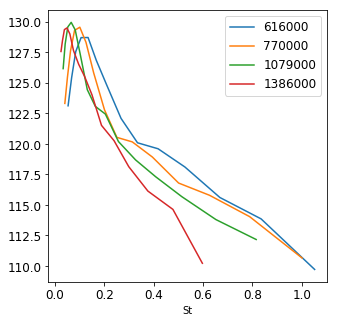

In [224]:
plt.figure(figsize=(5,5))
df.groupby(["Re"])["Pres_level"].plot()
plt.tick_params(axis='both', which='major', labelsize=12)
#plt.xlabel("St")
#plt.ylabel("P [дБ]")
plt.legend(loc="best", fontsize=12)
plt.savefig('fig1a.png', dpi=300, bbox_inches='tight')

In [225]:
df = data[(data["Alpha"] == 22.2)]
df.Re = df.Re.apply(lambda x: int(round(x,-3)))
df = df.set_index("St")

In [226]:
df.Re.unique()

array([115000,  64000])

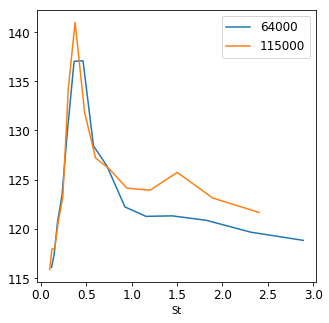

In [227]:
plt.figure(figsize=(5,5))
df.groupby(["Re"])["Pres_level"].plot()
plt.tick_params(axis='both', which='major', labelsize=12)
#plt.xlabel("St")
#plt.ylabel("P [дБ]")
plt.legend(loc="best", fontsize=12)
plt.savefig('fig1b.png', dpi=300, bbox_inches='tight')

### Models

In [233]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.binary):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=22)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.tick_params(axis='both', which='major', labelsize=32)
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], fontsize=32,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    #plt.ylabel('Факт', fontsize=22)
    #plt.xlabel('Модель', fontsize=22)

In [60]:
def data_preprocess(data):
    final_data = data.copy()
    

    
    return final_data

In [86]:
seed=47
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=0.2)

In [87]:
features = data_preprocess(X_train)
train_feat = features
train_labels = y_train

In [88]:
print(sum(y_train), sum(y_test))

655.0 165.0


In [89]:
def show_cv(clf_i, name, f, l, cv, score='roc_auc', param=None, vbs=False):
    if param: 
        grid_cv = GridSearchCV(
            clf_i,
            param,
            scoring=score,
            cv=cv,
            verbose=vbs,
            n_jobs=-1
        )
        grid_cv.fit(f, l)
        clf_i = grid_cv.best_estimator_
        print(grid_cv.best_params_)
    score = cross_val_score(clf_i,f,l,cv=cv, scoring=score, n_jobs=-1)
    print(name, score.mean(), score.std(), score.min(), score.max())

In [90]:
np.random.seed(seed)

In [91]:
scaler = StandardScaler()
model_rc = RidgeClassifier()
model_knn = KNeighborsClassifier()
model_lr = LogisticRegression()
model_svm = LinearSVC()
model_radsvm = SVC()
model_t = DecisionTreeClassifier()
model_rf = RandomForestClassifier()
model_gb = XGBClassifier()
model_mlp = MLPClassifier()
pipeline_rc = make_pipeline(scaler, model_rc)
pipeline_svm = make_pipeline(scaler, model_svm)
pipeline_lr = make_pipeline(scaler, model_lr)
pipeline_radsvm = make_pipeline(scaler, model_radsvm)
pipeline_knn = make_pipeline(scaler, model_knn)
pipeline_mlp = make_pipeline(scaler, model_mlp)


clfs = [
    ['Ridge',pipeline_rc],
    ['KNN', pipeline_knn],
    ['LR', pipeline_lr], 
    ['SVM L', pipeline_svm],
    ['SVM NL', pipeline_radsvm],
    ['DT', model_t],
    ['RF', model_rf],
    ['GB', model_gb],
    ['MLP', pipeline_mlp]
]

cv = KFold(n_splits=10, shuffle=True, random_state=seed).get_n_splits(train_feat,train_labels)
for name, cl in clfs:
    show_cv(cl, name, train_feat, train_labels, cv)

Ridge 0.8704180264180265 0.024812094784718422 0.8196581196581196 0.906060606060606
KNN 0.9284770784770785 0.021425410419760624 0.888888888888889 0.9539886039886041
LR 0.8845803018530292 0.022754218304803172 0.862097902097902 0.9388429752066116
SVM L 0.883107720562266 0.02333885316374552 0.8590209790209791 0.9374655647382921
SVM NL 0.9035378493560311 0.021378487654375614 0.8696503496503496 0.9509641873278236
DT 0.8929422429422429 0.02635275198389874 0.848951048951049 0.926068376068376
RF 0.9710019542746815 0.018542655952232326 0.9320512820512821 0.9924501424501424
GB 0.9692228108591745 0.014710260379094028 0.9337062937062937 0.9894586894586895
MLP 0.9502824044642229 0.01517839336487931 0.9183216783216782 0.965034965034965


In [92]:
clfs = [
    ['Ridge',pipeline_rc],
    ['KNN', pipeline_knn],
    ['LR', pipeline_lr], 
    ['SVM L', pipeline_svm],
    ['SVM NL', pipeline_radsvm],
    ['DT', model_t],
    ['RF', model_rf],
    ['GB', model_gb],
    ['MLP', pipeline_mlp]
]

parameters={
    
    'Ridge': {
        'ridgeclassifier__alpha': np.linspace(0.001, 100, num=20)
    },
    
    'KNN': {
        'kneighborsclassifier__n_neighbors': np.arange(3, 15, 1),
        'kneighborsclassifier__weights': ['uniform','distance']
    },
   
    'LR': {
        'logisticregression__C': np.linspace(0.001, 100, num=20),
        'logisticregression__penalty': ['l1','l2']
    },
   
    'SVM L': {
        'linearsvc__C': np.linspace(0.001, 100, num=20),
        'linearsvc__penalty': ['l2']
    },
    
      'SVM NL': {
        'svc__C': np.linspace(0.001,100,num=20),
        'svc__kernel': ['poly','rbf'],
        'svc__degree': [2,3]
    },
    
        
    'DT': {
        'max_depth': [6,8,10,12,15],
        'max_features': [0.3,0.5,0.7,0.9,1.0],
        'min_samples_split': [2,5,10],
        'min_samples_leaf': [2,5,10]
    },
        
    'RF': {
        'n_estimators': [50, 100, 200, 300, 500],
        'max_depth': [8,10,12,15,18],
        'min_samples_split': [2,5,10],
        'min_samples_leaf': [2,5,10],
    },
    'GB': {
        'n_estimators': [20, 50, 60, 75, 100, 200],
        'learning_rate': np.linspace(0.001, 0.5, num=20),
        'max_depth': [3,5,7],
    },

    'MLP': {
        'mlpclassifier__hidden_layer_sizes': [(20,), (50,), (100,)],
        'mlpclassifier__activation': ['relu','logistic'],
    }
}

for name, cl in clfs:
    show_cv(cl, name, train_feat, train_labels, cv, param=parameters.get(name), vbs=True)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.7s finished


{'ridgeclassifier__alpha': 100.0}
Ridge 0.8715033787761062 0.024517143359375455 0.8216524216524217 0.9079889807162534
Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    0.7s finished


{'kneighborsclassifier__n_neighbors': 14, 'kneighborsclassifier__weights': 'distance'}
KNN 0.9512078123896306 0.02003454042649877 0.9113960113960113 0.9801652892561983
Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.2s


{'logisticregression__C': 10.527210526315788, 'logisticregression__penalty': 'l2'}


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    1.3s finished


LR 0.8855365779002142 0.021897166825213032 0.8657342657342657 0.937465564738292
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    1.7s finished


{'linearsvc__C': 52.63205263157894, 'linearsvc__penalty': 'l2'}
SVM L 0.8796005745096653 0.022200369798036083 0.8388811188811189 0.928374655647383
Fitting 10 folds for each of 80 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    2.9s finished


{'svc__C': 100.0, 'svc__degree': 2, 'svc__kernel': 'rbf'}
SVM NL 0.9720215205669753 0.009311601915483457 0.9595441595441596 0.9888888888888889
Fitting 10 folds for each of 225 candidates, totalling 2250 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1000 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 2250 out of 2250 | elapsed:    2.3s finished


{'max_depth': 10, 'max_features': 0.9, 'min_samples_leaf': 10, 'min_samples_split': 5}
DT 0.9388301664665301 0.019407847012077494 0.9123076923076923 0.9643250688705234
Fitting 10 folds for each of 225 candidates, totalling 2250 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 231 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 481 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 831 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 1281 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done 1831 tasks      | elapsed:   51.4s
[Parallel(n_jobs=-1)]: Done 2250 out of 2250 | elapsed:  1.1min finished


{'max_depth': 18, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
RF 0.97739257375621 0.013602124575343027 0.9437762237762237 0.992022792022792
Fitting 10 folds for each of 360 candidates, totalling 3600 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 520 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 1520 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 2920 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 3600 out of 3600 | elapsed:   14.4s finished


{'learning_rate': 0.3161578947368421, 'max_depth': 7, 'n_estimators': 100}
GB 0.9790941112759295 0.015456813997546335 0.9426573426573427 0.9957264957264957
Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.2min finished


{'mlpclassifier__activation': 'relu', 'mlpclassifier__hidden_layer_sizes': (100,)}
MLP 0.9529923477196205 0.013850588911499092 0.923076923076923 0.9692307692307692


In [188]:
import numpy as np
import pandas as pd

from hyperopt import hp, tpe, Trials
from hyperopt.fmin import fmin

In [189]:
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']),
        'learning_rate': float(params['learning_rate']),
        'max_depth': int(params['max_depth']),
        'gamma': "{:.3f}".format(params['gamma']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
        'min_child_weight': int(params['min_child_weight']),
        'reg_alpha': float(params['reg_alpha'])
    }
    
    clf = XGBClassifier(
        n_jobs=6,
        **params
    )
    
    score = cross_val_score(clf, train_feat, train_labels, scoring='roc_auc', cv=cv).mean()
    print("AUC {:.3f} params {}".format(score, params))
    return score

space = {
    'n_estimators': hp.quniform('n_estimators', 50, 1000, 100),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.quniform('max_depth', 3, 9, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
    'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
    'gamma': hp.uniform('gamma', 0.0, 0.5),
    'reg_alpha': hp.uniform('reg_alpha', 1e-5, 100)
}

trials=Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            trials=trials,
            max_evals=300)

AUC 0.914 params {'n_estimators': 500, 'learning_rate': 0.1887548185364322, 'max_depth': 4, 'gamma': '0.129', 'colsample_bytree': '0.531', 'min_child_weight': 6, 'reg_alpha': 77.81734338469627}
AUC 0.923 params {'n_estimators': 400, 'learning_rate': 0.2854299558626661, 'max_depth': 4, 'gamma': '0.111', 'colsample_bytree': '0.349', 'min_child_weight': 5, 'reg_alpha': 30.704409200048666}
AUC 0.942 params {'n_estimators': 300, 'learning_rate': 0.2666607612427209, 'max_depth': 5, 'gamma': '0.317', 'colsample_bytree': '0.360', 'min_child_weight': 3, 'reg_alpha': 13.19012686261025}
AUC 0.912 params {'n_estimators': 700, 'learning_rate': 0.1236676981565319, 'max_depth': 8, 'gamma': '0.380', 'colsample_bytree': '0.438', 'min_child_weight': 1, 'reg_alpha': 87.37452611634465}
AUC 0.949 params {'n_estimators': 500, 'learning_rate': 0.07403142424833432, 'max_depth': 4, 'gamma': '0.243', 'colsample_bytree': '0.618', 'min_child_weight': 1, 'reg_alpha': 12.795340380000349}
AUC 0.922 params {'n_estima

AUC 0.950 params {'n_estimators': 700, 'learning_rate': 0.24955338584406903, 'max_depth': 8, 'gamma': '0.253', 'colsample_bytree': '0.883', 'min_child_weight': 4, 'reg_alpha': 11.819225275205284}
AUC 0.916 params {'n_estimators': 800, 'learning_rate': 0.17942668998783148, 'max_depth': 9, 'gamma': '0.399', 'colsample_bytree': '0.637', 'min_child_weight': 5, 'reg_alpha': 92.26539416822547}
AUC 0.920 params {'n_estimators': 900, 'learning_rate': 0.2571211140147681, 'max_depth': 8, 'gamma': '0.333', 'colsample_bytree': '0.591', 'min_child_weight': 3, 'reg_alpha': 70.32949602979878}
AUC 0.925 params {'n_estimators': 600, 'learning_rate': 0.27661943851351434, 'max_depth': 9, 'gamma': '0.428', 'colsample_bytree': '0.458', 'min_child_weight': 4, 'reg_alpha': 34.45405014720753}
AUC 0.928 params {'n_estimators': 100, 'learning_rate': 0.20000000679731106, 'max_depth': 7, 'gamma': '0.371', 'colsample_bytree': '0.754', 'min_child_weight': 3, 'reg_alpha': 60.03964888302749}
AUC 0.915 params {'n_esti

AUC 0.975 params {'n_estimators': 400, 'learning_rate': 0.2005888431795765, 'max_depth': 8, 'gamma': '0.219', 'colsample_bytree': '0.563', 'min_child_weight': 2, 'reg_alpha': 0.07930585557640057}
AUC 0.928 params {'n_estimators': 900, 'learning_rate': 0.23270167253370025, 'max_depth': 7, 'gamma': '0.241', 'colsample_bytree': '0.947', 'min_child_weight': 4, 'reg_alpha': 60.43019226112552}
AUC 0.918 params {'n_estimators': 900, 'learning_rate': 0.2096755354153177, 'max_depth': 9, 'gamma': '0.151', 'colsample_bytree': '0.999', 'min_child_weight': 3, 'reg_alpha': 91.08576056909203}
AUC 0.916 params {'n_estimators': 1000, 'learning_rate': 0.15057764374311766, 'max_depth': 6, 'gamma': '0.181', 'colsample_bytree': '0.607', 'min_child_weight': 4, 'reg_alpha': 85.65068537711868}
AUC 0.917 params {'n_estimators': 800, 'learning_rate': 0.24837059131821743, 'max_depth': 8, 'gamma': '0.421', 'colsample_bytree': '0.340', 'min_child_weight': 5, 'reg_alpha': 53.82307286944229}
AUC 0.927 params {'n_est

AUC 0.911 params {'n_estimators': 700, 'learning_rate': 0.1084614435618677, 'max_depth': 9, 'gamma': '0.212', 'colsample_bytree': '0.450', 'min_child_weight': 1, 'reg_alpha': 96.19089872309226}
AUC 0.909 params {'n_estimators': 900, 'learning_rate': 0.29944524521210447, 'max_depth': 8, 'gamma': '0.478', 'colsample_bytree': '0.339', 'min_child_weight': 6, 'reg_alpha': 99.79929659753918}
AUC 0.920 params {'n_estimators': 400, 'learning_rate': 0.15521127700705584, 'max_depth': 9, 'gamma': '0.450', 'colsample_bytree': '0.800', 'min_child_weight': 4, 'reg_alpha': 83.0447964611782}
AUC 0.910 params {'n_estimators': 100, 'learning_rate': 0.27361611332540636, 'max_depth': 7, 'gamma': '0.000', 'colsample_bytree': '0.316', 'min_child_weight': 5, 'reg_alpha': 73.50014165593578}
AUC 0.929 params {'n_estimators': 900, 'learning_rate': 0.251822365049513, 'max_depth': 8, 'gamma': '0.391', 'colsample_bytree': '0.699', 'min_child_weight': 5, 'reg_alpha': 32.45694346084053}
AUC 0.916 params {'n_estimato

AUC 0.903 params {'n_estimators': 800, 'learning_rate': 0.25424134140233084, 'max_depth': 9, 'gamma': '0.107', 'colsample_bytree': '0.391', 'min_child_weight': 4, 'reg_alpha': 96.5960032656698}
AUC 0.915 params {'n_estimators': 700, 'learning_rate': 0.27944483846892076, 'max_depth': 9, 'gamma': '0.056', 'colsample_bytree': '0.389', 'min_child_weight': 4, 'reg_alpha': 68.841987579223}
AUC 0.907 params {'n_estimators': 600, 'learning_rate': 0.2526281946869276, 'max_depth': 5, 'gamma': '0.110', 'colsample_bytree': '0.420', 'min_child_weight': 5, 'reg_alpha': 96.6229868262545}
AUC 0.955 params {'n_estimators': 700, 'learning_rate': 0.29914035802545413, 'max_depth': 8, 'gamma': '0.035', 'colsample_bytree': '0.672', 'min_child_weight': 3, 'reg_alpha': 10.160115120942393}
AUC 0.916 params {'n_estimators': 800, 'learning_rate': 0.2562702907240791, 'max_depth': 6, 'gamma': '0.065', 'colsample_bytree': '0.644', 'min_child_weight': 4, 'reg_alpha': 88.70026763779144}
AUC 0.913 params {'n_estimator

AUC 0.904 params {'n_estimators': 500, 'learning_rate': 0.2702238453143671, 'max_depth': 6, 'gamma': '0.285', 'colsample_bytree': '0.388', 'min_child_weight': 3, 'reg_alpha': 89.9695798927548}
AUC 0.920 params {'n_estimators': 400, 'learning_rate': 0.01615214686604069, 'max_depth': 6, 'gamma': '0.265', 'colsample_bytree': '0.380', 'min_child_weight': 2, 'reg_alpha': 56.717437392378166}
AUC 0.923 params {'n_estimators': 500, 'learning_rate': 0.28930019682346686, 'max_depth': 6, 'gamma': '0.332', 'colsample_bytree': '0.724', 'min_child_weight': 3, 'reg_alpha': 68.05823786716653}
AUC 0.917 params {'n_estimators': 400, 'learning_rate': 0.26856531312557175, 'max_depth': 6, 'gamma': '0.307', 'colsample_bytree': '0.326', 'min_child_weight': 2, 'reg_alpha': 63.74044892291295}
AUC 0.912 params {'n_estimators': 500, 'learning_rate': 0.299537539595565, 'max_depth': 7, 'gamma': '0.245', 'colsample_bytree': '0.438', 'min_child_weight': 3, 'reg_alpha': 79.52894560420334}
AUC 0.909 params {'n_estimat

AUC 0.901 params {'n_estimators': 700, 'learning_rate': 0.2647676943943238, 'max_depth': 7, 'gamma': '0.232', 'colsample_bytree': '0.365', 'min_child_weight': 1, 'reg_alpha': 98.30871628805744}
AUC 0.905 params {'n_estimators': 700, 'learning_rate': 0.25435595135069955, 'max_depth': 7, 'gamma': '0.226', 'colsample_bytree': '0.368', 'min_child_weight': 1, 'reg_alpha': 99.76381142078087}
AUC 0.902 params {'n_estimators': 700, 'learning_rate': 0.27983605228250064, 'max_depth': 7, 'gamma': '0.162', 'colsample_bytree': '0.349', 'min_child_weight': 1, 'reg_alpha': 93.5176209972353}
AUC 0.902 params {'n_estimators': 700, 'learning_rate': 0.2797817744388687, 'max_depth': 7, 'gamma': '0.179', 'colsample_bytree': '0.349', 'min_child_weight': 1, 'reg_alpha': 93.40951456406566}
AUC 0.903 params {'n_estimators': 700, 'learning_rate': 0.28083882998992743, 'max_depth': 7, 'gamma': '0.168', 'colsample_bytree': '0.317', 'min_child_weight': 1, 'reg_alpha': 93.39227699749529}
AUC 0.908 params {'n_estimat

In [191]:
print(sorted(trials.results, key=lambda x: x['loss'], reverse=True)[0])
print("Hyperopt estimated optimum {}".format(best))

{'loss': 0.9767851946033765, 'status': 'ok'}
Hyperopt estimated optimum {'colsample_bytree': 0.33500052637046357, 'gamma': 0.13779613494015658, 'learning_rate': 0.2902228033761467, 'max_depth': 7.0, 'min_child_weight': 1.0, 'n_estimators': 700.0, 'reg_alpha': 97.97464846209559}


In [93]:
features = data_preprocess(X_test)
test_feat = features
test_labels = y_test

In [94]:
print(sum(train_labels), len(train_feat), sum(test_labels), len(test_feat))

655.0 1202 165.0 301


In [230]:
scaler = StandardScaler()
final_model1 = DecisionTreeClassifier(max_depth=15,max_features=0.9, min_samples_leaf=10, 
                                      min_samples_split=5,random_state=seed)
final_model2 = make_pipeline(scaler, LogisticRegression(C=10.52, penalty='l2', random_state=seed))
final_model3 = RandomForestClassifier(n_estimators=300, max_depth=18, min_samples_split=2, min_samples_leaf=2,
                                      n_jobs=5, random_state=seed)
final_model4 = XGBClassifier(n_estimators=100, learning_rate=0.3161, max_depth=7, random_state=seed)

In [231]:
final_model1.fit(train_feat, train_labels)
final_model2.fit(train_feat, train_labels)
final_model3.fit(train_feat, train_labels)
final_model4.fit(train_feat, train_labels)

predict = []
predict.append(final_model1.predict_proba(test_feat))
predict.append(final_model2.predict_proba(test_feat))
predict.append(final_model3.predict_proba(test_feat))
predict.append(final_model4.predict_proba(test_feat))

for n, model_name in enumerate(['DT', 'LR', 'RF', 'GB']):
    print(model_name, roc_auc_score(test_labels, [x[1] for x in predict[n]]))

DT 0.9276960784313726
LR 0.9135026737967914
RF 0.9640597147950088
GB 0.966934046345811


In [194]:
test = pd.concat((X_test, y_test), axis=1)
test['predict_DT'] = [x[1] for x in predict[0]]
test['predict_LR'] = [x[1] for x in predict[1]]
test['predict_RF'] = [x[1] for x in predict[2]]
test['predict_GB'] = [x[1] for x in predict[3]]

final_pred = test[[
    'predict_DT',
    'predict_LR',
    'predict_RF',
    'predict_GB',
    'High_Pres_level'
]].sort_values('predict_GB', ascending=False)

final_pred.index = range(final_pred.shape[0])

In [195]:
final_pred.head()

,predict_DT,predict_LR,predict_RF,predict_GB,High_Pres_level
0,1.000000,0.899060,0.992692,0.999991,1.0
1,1.000000,0.804290,0.995426,0.999989,1.0
2,0.636364,0.920116,0.992986,0.999987,1.0
3,1.000000,0.865758,0.990245,0.999979,1.0
4,1.000000,0.890483,0.995704,0.999978,1.0


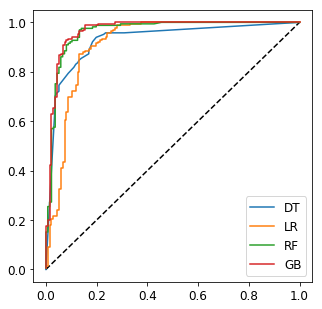

In [229]:
fpr_dt, tpr_dt, _ = roc_curve(final_pred['High_Pres_level'], final_pred['predict_DT'])
fpr_lr, tpr_lr, _ = roc_curve(final_pred['High_Pres_level'], final_pred['predict_LR'])
fpr_rf, tpr_rf, _ = roc_curve(final_pred['High_Pres_level'], final_pred['predict_RF'])
fpr_gb, tpr_gb, _ = roc_curve(final_pred['High_Pres_level'], final_pred['predict_GB'])

plt.figure(figsize=(5,5))
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_dt, tpr_dt, label='DT')
plt.plot(fpr_lr, tpr_lr, label='LR')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_gb, tpr_gb, label='GB')
plt.tick_params(axis='both', which='major', labelsize=12)
#plt.xlabel('FPR')
#plt.ylabel('TPR')
#plt.title('ROC кривая')
plt.legend(loc='best', fontsize=12)
plt.savefig('fig2b.png', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 432x288 with 0 Axes>

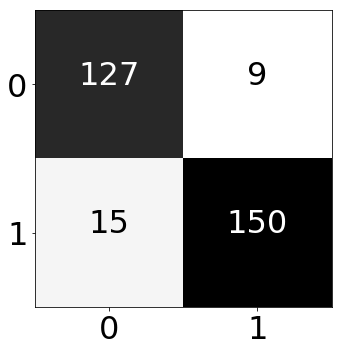

Recall:  [0.93 0.91] 

Precision:  [0.89 0.94] 

AUC ROC:  0.966934046345811
AUC PRC:  0.9613163200168512


In [234]:
# Gradient Boosting by Decision Trees
y_pred = final_model4.predict(test_feat)
y_pred_proba = final_model4.predict_proba(test_feat)[:,1]

conf_matrix = confusion_matrix(test_labels, y_pred)
precision, recall, thresholds = precision_recall_curve(test_labels, y_pred_proba)
np.set_printoptions(precision=2)

class_names = [0,1]
plt.figure()
plot_confusion_matrix(conf_matrix, classes=class_names, title='')
plt.savefig('fig2b1.png', dpi=300, bbox_inches='tight')
plt.show()

#print "Confusion matrix:\n", conf_matrix,"\n",
print ("Recall: ", recall_score(test_labels, y_pred, average=None), '\n')
print ("Precision: ", precision_score(test_labels, y_pred, average=None), '\n')
print ("AUC ROC: ", roc_auc_score(test_labels, y_pred_proba))
print ("AUC PRC: ", auc(recall, precision))

In [125]:
conf_matrix

array([[127,   9],
       [ 15, 150]])

In [101]:
feature_names = X.columns
importances = final_model4.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature importances:")
for f, idx in enumerate(indices):
    print("{:2d}. feature '{:5s}' ({:.4f})".format(f+1, feature_names[idx], importances[idx]))

Feature importances:
 1. feature 'Stl  ' (0.2162)
 2. feature 'St   ' (0.2099)
 3. feature 'Ro   ' (0.1839)
 4. feature 'Delta' (0.1547)
 5. feature 'Ma   ' (0.0900)
 6. feature 'Re   ' (0.0742)
 7. feature 'Alpha' (0.0710)


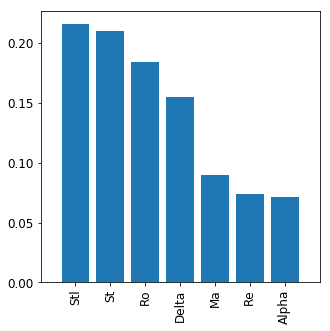

In [239]:
d_first = 7
plt.figure(figsize=(5,5))
#plt.title("Feature importances")
plt.bar(range(d_first), importances[indices[:d_first]], align='center')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xticks(range(d_first), np.array(feature_names)[indices[:d_first]], rotation=90)
plt.xlim([-1, d_first])
plt.savefig('fig3a.png', dpi=300, bbox_inches='tight')

In [103]:
import shap
import xgboost as xgb

shap.initjs()

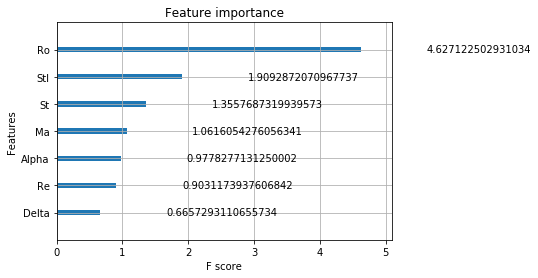

In [104]:
xgb.plot_importance(final_model4, importance_type='gain')

In [236]:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

param = {'max_depth': 7, 'learning_rate': 0.3161} 
num_boost_round = 100
model = xgb.train(param, dtrain, num_boost_round)

In [237]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(dtest) # what dataframe we use 

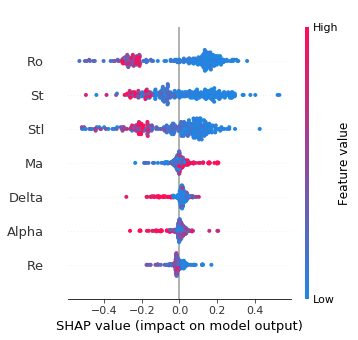

In [238]:
plt.figure(figsize=(5,5))
shap.summary_plot(shap_values,X_test,auto_size_plot=False,plot_type="dot",show=False)
plt.savefig('fig3b.png', dpi=300, bbox_inches='tight')
plt.show()